### MMDetection 설치
* 강의 영상에는 pip install mmcv-full로 mmcv를 설치(약 10분 정도의 시간이 소요)
* 실습코드는 pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html 로 변경(설치에 12초 정도 걸림. 2022.09).
* 코랩의 pytorch 버전이 2.0으로 upgrade되었으나 mmdetection은 아직 pytorch 2.0을 지원하지 않기에 pytorch 1.13으로 downgrade 필요(2023.04월에 코랩 pytorch upgrade)
*  2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준으므로 mmdetection 2.x 소스코드 설치 필요.   

In [1]:
#코랩의 pytorch 버전이 2.0으로 upgrade됨.
import torch
print(torch.__version__)

2.1.0+cu118


In [ ]:
#현재 mmdetection이 pytorch 2.x를 지원하지 않음. pytorch 1.13+ CUDA 116 환경으로 코랩 커널 downgrade
# downgrade 설치시 ERROR: pip's dependency resolver... 부분은 신경쓰지 않아도 됨.
!pip install -q torch==1.13.0+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함. https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html

In [ ]:
# 2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준임.
# mmdetection 2.x branch의 소스코드 기반으로 mmdetection 설치 필요.
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [ ]:
!pip install -q yapf==0.40.1 # pretty text를 위해서 설치

In [1]:
# 아래를 수행하기 전에 kernel을 restart 해야 함.
from mmdet.apis import init_detector, inference_detector
import mmcv

/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.13.0+cu116 (Tesla T4)


### MS-COCO 데이터 기반으로 Mask RCNN Pretrained 모델을 활용하여 Inference 수행
* Mask RCNN Pretrained 모델 다운로드
* Mask RCNN용 Config 파일 설정.  
* Inference 용 모델을 생성하고, Inference 적용

In [3]:
# pretrained weight 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬.
!cd mmdetection; mkdir checkpoints

In [4]:
!wget -O /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

--2023-11-18 13:50:08--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.25.82.208, 8.25.82.211, 8.25.82.209, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.25.82.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254089599 (242M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’

/content/mmdetectio 100%[===================>] 242.32M  13.6MB/s    in 20s     

2023-11-18 13:50:30 (12.0 MB/s) - ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’ saved [254089599/254089599]



In [5]:
!ls -lia /content/mmdetection/checkpoints

total 248144
2231819 drwxr-xr-x  2 root root      4096 Nov 18 13:50 .
2228335 drwxr-xr-x 19 root root      4096 Nov 18 13:50 ..
2231820 -rw-r--r--  1 root root 254089599 Nov  2  2021 mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


In [2]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정.
config_file = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [3]:
# config 파일과 pretrained 모델을 기반으로 Detector 모델을 생성.
from mmdet.apis import init_detector, inference_detector

model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


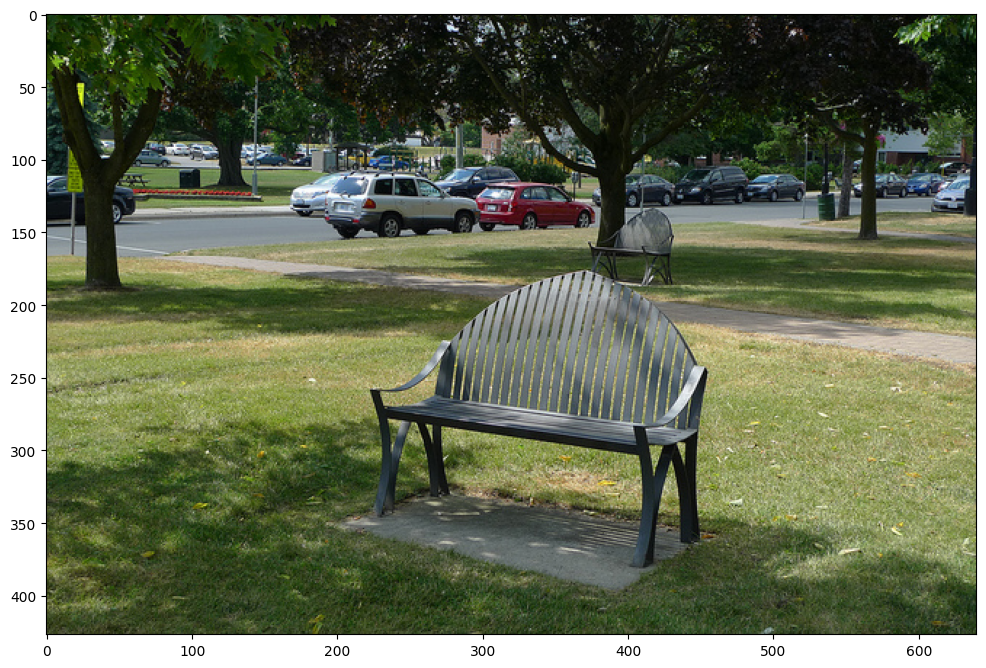

In [4]:
import cv2
import matplotlib.pyplot as plt
img = '/content/mmdetection/demo/demo.jpg'

img_arr  = cv2.imread(img)
img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_arr_rgb)

In [5]:
img_path = '/content/mmdetection/demo/demo.jpg'
# inference_detector의 인자로 string(file경로), ndarray가 단일 또는 list형태로 입력 될 수 있음.
results = inference_detector(model, img_arr)

/usr/local/lib/python3.10/dist-packages/mmdet-2.28.2-py3.10.egg/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


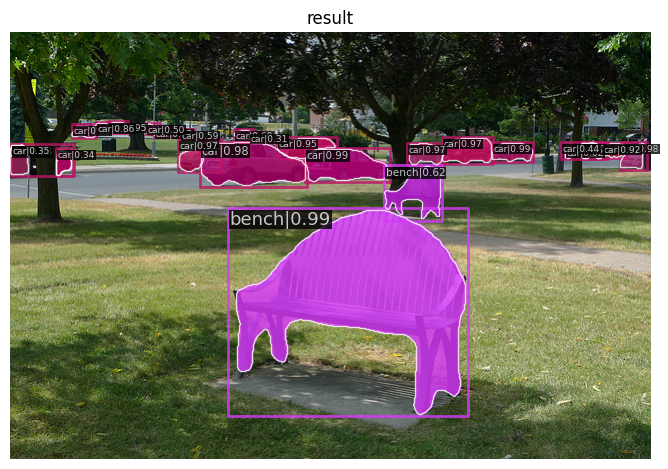

In [6]:
from mmdet.apis import show_result_pyplot
# inference 된 결과를 원본 이미지에 적용하여 새로운 image로 생성(bbox 처리된 image)
# Default로 score threshold가 0.3 이상인 Object들만 시각화 적용. show_result_pyplot은 model.show_result()를 호출.
show_result_pyplot(model, img_arr, results)

### Inference 결과로 반환되는 results 값 살펴 보기
* inference_detector(model, img_path)의 결과로 반환되는 값은 instance segmentation 일 경우 Object Detection 결과에 추가되어 segmentation masking 정보도 함께 반환됨

In [11]:
type(results), len(results) # 80개의 bbox와 80개의 masking 정보라서 길이가 2

(tuple, 2)

In [16]:
results[0][:2], results[1][:2]

([array([[5.3380640e+02, 1.0804523e+02, 5.4053583e+02, 1.2511749e+02,
          9.9973507e-02]], dtype=float32),
  array([], shape=(0, 5), dtype=float32)],
 [[array([[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]])],
  []])

In [17]:
print(type(results[0]), len(results[0]), type(results[1]), len(results[1]) )

<class 'list'> 80 <class 'list'> 80


In [18]:
'''results[0]는 list형으로 coco class의  0부터 79까지 class_id별로 80개의 array를 가짐.
개별 array들은 각 클래스별로 5개의 값(좌표값과 class별로 confidence)을 가짐. 개별 class별로 여러개의 좌표를 가지면 여러개의 array가 생성됨.
좌표는 좌상단(xmin, ymin), 우하단(xmax, ymax) 기준.
개별 array의 shape는 (Detection된 object들의 수, 5(좌표와 confidence)) 임
'''
print(type(results[0][0]), results[0][0].shape, results[0][1].shape, results[0][2].shape) # 클래스 2번. 45개의 자동차가 있음

<class 'numpy.ndarray'> (1, 5) (0, 5) (45, 5)


In [19]:
# results[1]은 masking 정보를 가짐. coco class의  0부터 79까지 class_id 별로 80개의 list를 가짐. 개별 list는 개별 object의 mask 정보를 내부 원소로 가짐.
# 개별 object의 mask 정보는 2차원 array로서 image의 height x width 형태를 가짐.
print('results[1]의 첫번째 원소의 type과 size:', type(results[1][0]), len(results[1][0]), '두번째 원소 사이즈:', len(results[1][1]), '세번째 원소 사이즈:', len(results[1][2]))
print('results[1]의 첫번째 원소 list의 첫번째 원소 type과 shape:', type(results[1][0][0]), results[1][0][0].shape)
#print('results[1]의 두번째 원소 list의 첫번째 원소 type과 shape:', type(results[1][1][0]))
print('results[1]의 세번째 원소 list의 첫번째/두번째/세번째 원소 shape:', results[1][2][0].shape, results[1][2][1].shape, results[1][2][2].shape)
print('image shape:', img_arr.shape)

results[1]의 첫번째 원소의 type과 size: <class 'list'> 1 두번째 원소 사이즈: 0 세번째 원소 사이즈: 45
results[1]의 첫번째 원소 list의 첫번째 원소 type과 shape: <class 'numpy.ndarray'> (427, 640)
results[1]의 세번째 원소 list의 첫번째/두번째/세번째 원소 shape: (427, 640) (427, 640) (427, 640)
image shape: (427, 640, 3)


In [20]:
mask_imsi = results[1][0][0]
print(mask_imsi)
print(mask_imsi[mask_imsi > 0], mask_imsi[mask_imsi == 0])

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True] [False False False ... False False False]


In [21]:
mask_imsi.shape

(427, 640)

In [22]:
import numpy as np

mask_index = np.where(mask_imsi > 0)

In [23]:
np.array(mask_index)

array([[109, 109, 109, 110, 110, 110, 110, 111, 111, 111, 111, 112, 112,
        112, 112, 112, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114,
        115, 115, 115, 115, 115, 116, 116, 116, 116, 117, 117, 117, 117,
        118, 118, 118, 118, 119, 119, 119, 119, 119, 120, 120, 120, 120,
        120, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 123, 123,
        123, 123, 123, 124, 124, 124, 124],
       [537, 538, 539, 536, 537, 538, 539, 536, 537, 538, 539, 535, 536,
        537, 538, 539, 535, 536, 537, 538, 539, 535, 536, 537, 538, 539,
        535, 536, 537, 538, 539, 535, 536, 537, 538, 535, 536, 537, 538,
        535, 536, 537, 538, 534, 535, 536, 537, 538, 534, 535, 536, 537,
        538, 534, 535, 536, 537, 538, 534, 535, 536, 537, 538, 534, 535,
        536, 537, 538, 534, 535, 536, 537]])

In [24]:
img_arr_rgb_copy = img_arr_rgb.copy()
img_arr_rgb_copy[mask_index[0], mask_index[1], :] =0

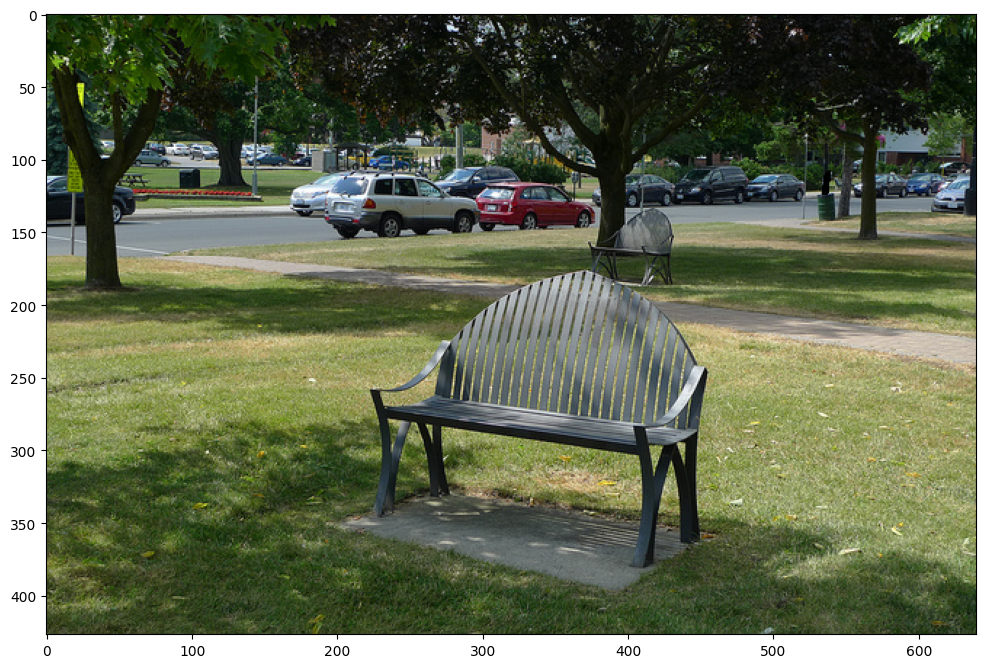

In [25]:
plt.figure(figsize=(12, 12))
plt.imshow(img_arr_rgb_copy)

(-0.5, 639.5, 426.5, -0.5)

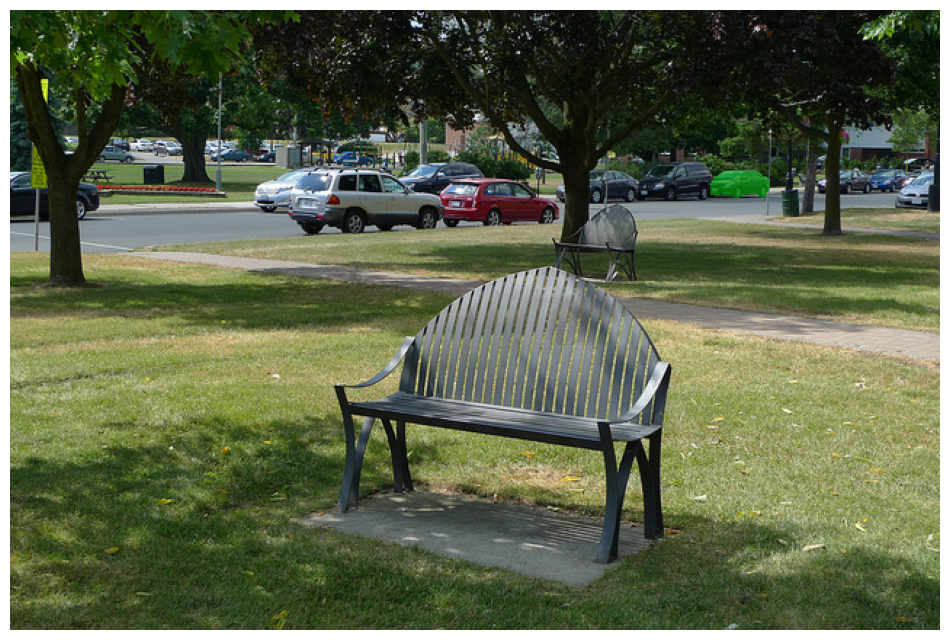

In [26]:
import numpy as np

def apply_mask(image, mask, color, alpha=0.5):
  for c in range(3):
    # mask값이 1일 경우는 원본 pixel값에 컬러 segmentation을 적용하고, 그렇지 않을 경우 원본 pixel값을 그대로 유지.
    image[:, :, c] = np.where(mask == 1,
                              image[:, :, c] *
                              (1 - alpha) + alpha * color[c] * 255,
                              image[:, :, c])
  return image


draw_img = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
masked_image = apply_mask(draw_img, results[1][2][0], (0, 255, 0), alpha=0.6) # 자동차 중 하나 그리기
plt.figure(figsize=(12, 14))
plt.imshow(masked_image)
plt.axis('off')

### Video Detection 실행
* mmdetection의 model.show_result()를 실행하여 frame별로 object detect 된 결과를 시각화

In [27]:
!mkdir data

In [28]:
!wget -O /content/data/John_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2023-11-18 13:59:45--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2023-11-18 13:59:45--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2023-11-18 13:59:46--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

In [29]:
# https://github.com/open-mmlab/mmdetection/blob/master/demo/video_demo.py 대로 video detection 수행.
import cv2

video_reader = mmcv.VideoReader('/content/data/John_Wick_small.mp4')
video_writer = None
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('/content/data/John_Wick_small_out1.mp4', fourcc, video_reader.fps,(video_reader.width, video_reader.height))

for frame in mmcv.track_iter_progress(video_reader):
  result = inference_detector(model, frame)
  frame = model.show_result(frame, result, score_thr=0.4) # 시각화

  video_writer.write(frame)

if video_writer:
        video_writer.release()

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 58/58, 2.6 task/s, elapsed: 22s, ETA:     0s


### segmentation 시각화 함수 직접 작성 후 단일 이미지와 Video inference 수행.

In [7]:
# 0부터 순차적으로 클래스 매핑된 label 적용.
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250]] )

In [8]:
#mask threshold값은 mask_thr_binary=0.5 로 지정되어 있음.
print(model.cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=None),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0

In [9]:
# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성.
# 이미 inference 시 mask boolean값이 들어오므로 mask_threshold 값을 필요하지 않음.
def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사.
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음.
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list.
  results = inference_detector(model, img_array)
  bbox_results = results[0]
  seg_results = results[1]

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐.
  for result_ind, bbox_result in enumerate(bbox_results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행.
    if len(bbox_result) == 0:
      continue

    mask_array_list = seg_results[result_ind]

    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출.
    for i in range(len(bbox_result)):
      # 좌상단, 우하단 좌표 추출.
      if bbox_result[i, 4] > score_threshold:
        left = int(bbox_result[i, 0])
        top = int(bbox_result[i, 1])
        right = int(bbox_result[i, 2])
        bottom = int(bbox_result[i, 3])
        caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i, 4])
        cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
        # masking 시각화 적용. class_mask_array는 image 크기 shape의  True/False값을 가지는 2차원 array
        class_mask_array = mask_array_list[i]
        # 원본 image array에서 mask가 True인 영역만 별도 추출.
        masked_roi = draw_img[class_mask_array]
        #color를 임의 지정
        color_index = np.random.randint(0, len(colors)-1)
        # color를 class별로 지정
        #color_index = result_ind % len(colors)
        color = colors[color_index]
        # apply_mask()함수를 적용시 수행 시간이 상대적으로 오래 걸림.
        #draw_img = apply_mask(draw_img, class_mask_array, color, alpha=0.4)
        # 원본 이미지의 masking 될 영역에 mask를 특정 투명 컬러로 적용
        draw_img[class_mask_array] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * masked_roi).astype(np.uint8)
        if is_print:
          print(caption)

  return draw_img

In [10]:
img_arr = cv2.imread('/content/mmdetection/demo/demo.jpg')
mask_array = results[1][2][0]
print('image array shape:', img_arr.shape)
print('mask array shape:', mask_array.shape)
print('mask true array shape:', mask_array[mask_array].shape)
print('masked array shape:', img_arr[results[1][2][0]].shape)

image array shape: (427, 640, 3)
mask array shape: (427, 640)
mask true array shape: (628,)
masked array shape: (628, 3)


car: 0.9910
car: 0.9892
car: 0.9833
car: 0.9832
car: 0.9801
car: 0.9715
car: 0.9654
car: 0.9650
car: 0.9546
car: 0.9531
car: 0.9524
car: 0.9464
car: 0.9209
car: 0.9160
car: 0.8646
car: 0.6161
car: 0.5985
car: 0.5947
car: 0.5020
car: 0.4424
car: 0.3456
car: 0.3411
car: 0.3080
bench: 0.9872
bench: 0.6239


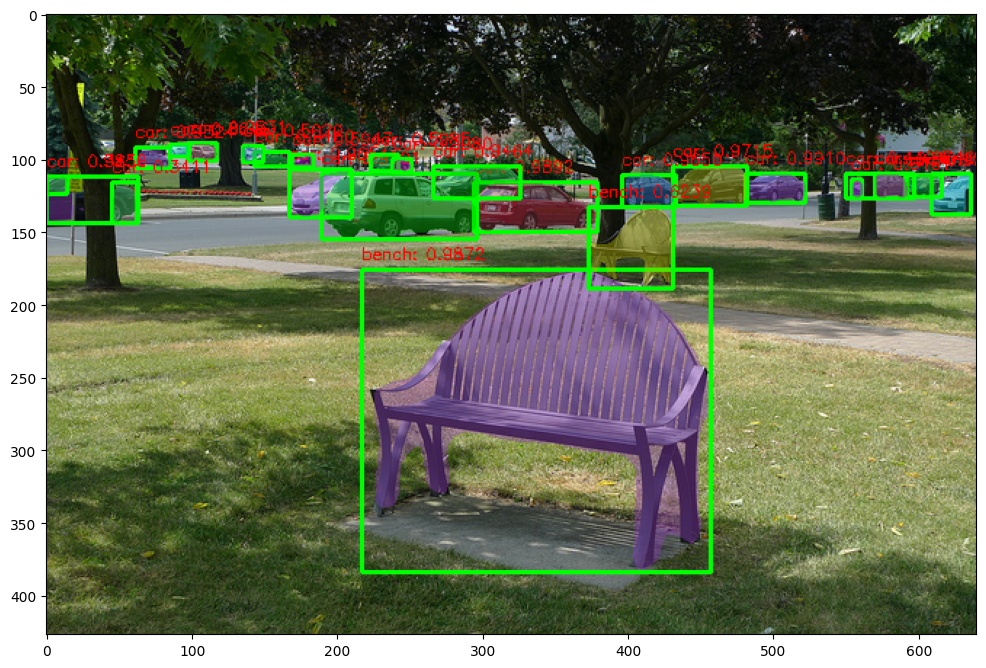

In [12]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/mmdetection/demo/demo.jpg')
detected_img = get_detected_img(model, img_arr,  score_threshold=0.3, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

In [13]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

mkdir: cannot create directory ‘/content/data’: File exists
--2023-11-18 14:02:55--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.04s   

2023-11-18 14:02:55 (8.45 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



person: 0.9992
person: 0.9991
person: 0.9980
person: 0.9974
person: 0.9378
car: 0.9596
car: 0.9578
car: 0.9487
car: 0.9288
car: 0.9221
car: 0.8884
car: 0.8715
car: 0.8034
car: 0.7781
car: 0.4521
car: 0.3580
car: 0.3103
truck: 0.3594
truck: 0.3297
tie: 0.5624
tie: 0.3392


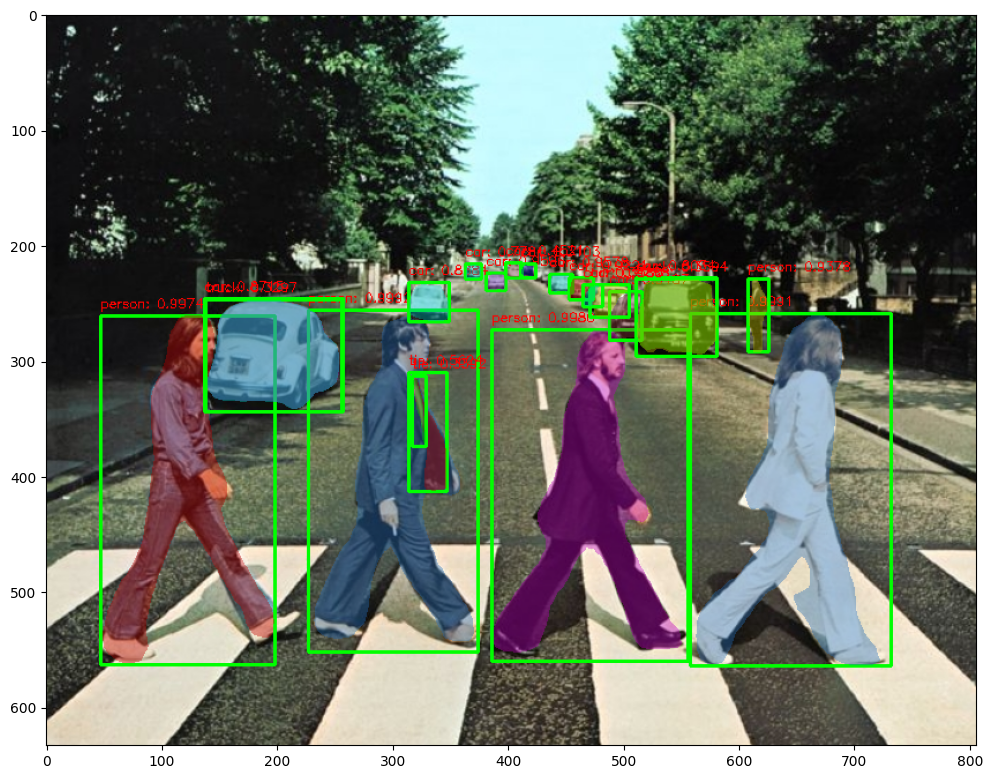

In [14]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/data/beatles01.jpg')
detected_img = get_detected_img(model, img_arr,  score_threshold=0.3, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(detected_img)

In [15]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold,is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [16]:
do_detected_video(model, '/content/data/John_Wick_small.mp4', '/content/data/John_Wick_small_out2.mp4', score_threshold=0.4, do_print=True)

총 Frame 갯수: 58
frame별 detection 수행 시간: 0.2777
frame별 detection 수행 시간: 0.1993
frame별 detection 수행 시간: 0.213
frame별 detection 수행 시간: 0.2309
frame별 detection 수행 시간: 0.2445
frame별 detection 수행 시간: 0.2422
frame별 detection 수행 시간: 0.2331
frame별 detection 수행 시간: 0.2248
frame별 detection 수행 시간: 0.2344
frame별 detection 수행 시간: 0.2505
frame별 detection 수행 시간: 0.2224
frame별 detection 수행 시간: 0.243
frame별 detection 수행 시간: 0.2405
frame별 detection 수행 시간: 0.2252
frame별 detection 수행 시간: 0.2289
frame별 detection 수행 시간: 0.2289
frame별 detection 수행 시간: 0.2075
frame별 detection 수행 시간: 0.2231
frame별 detection 수행 시간: 0.2026
frame별 detection 수행 시간: 0.1978
frame별 detection 수행 시간: 0.2031
frame별 detection 수행 시간: 0.2003
frame별 detection 수행 시간: 0.2047
frame별 detection 수행 시간: 0.1958
frame별 detection 수행 시간: 0.1926
frame별 detection 수행 시간: 0.2095
frame별 detection 수행 시간: 0.2005
frame별 detection 수행 시간: 0.1929
frame별 detection 수행 시간: 0.1887
frame별 detection 수행 시간: 0.201
frame별 detection 수행 시간: 0.1965
frame별 detection 수행 시간: 0.1